# Package and RMSES

In [1]:


import xarray as xr
from datetime import datetime

import torch

from aurora import AuroraSmall, Batch, Metadata, rollout
import matplotlib.pyplot as plt

from pathlib import Path

import cdsapi
import numpy as np
from sklearn.metrics import root_mean_squared_error
import gcsfs

from torch.utils.data import Dataset
from aurora import Batch, Metadata
import os
from matplotlib.colors import TwoSlopeNorm


import seaborn as sns



import seaborn as sns
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter  # <-- Add this import



import sys
sys.path.append(os.path.abspath("../src"))
from utils import get_surface_feature_target_data, get_atmos_feature_target_data
from utils import get_static_feature_target_data, create_batch, predict_fn, rmse_weights
from utils import rmse_fn, plot_rmses, create_hrest0_batch


# In[78]:


from evaluation_region_vs_region import evaluation_between_regions
from lora import create_custom_model, full_linear_layer_lora

torch.use_deterministic_algorithms(True)

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'


# # Data

/home/koomi_aims_ac_za/koomi/projects/AIMS-PROJECT/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# plot settings

In [2]:
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 15,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.linewidth': 0.8,
    'grid.linewidth': 1.2,
    'lines.linewidth': 1.5,
    'grid.alpha': 0.8,
    'figure.dpi': 150,
})

# Data

In [3]:

fs = gcsfs.GCSFileSystem(token="anon")

store = fs.get_mapper('gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr')
full_era5 = xr.open_zarr(store=store, consolidated=True, chunks=None)



start_time, end_time = '2022-01-01', '2022-01-03' 

  
sliced_era5 = (
    full_era5
    .sel(
        time=slice(start_time, end_time) 
    )
)

################################"" get hres data
store_hrest0 = fs.get_mapper('gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr')
full_hrest0 = xr.open_zarr(store=store_hrest0, consolidated=True, chunks=None)
sliced_hrest0 = full_hrest0.sel(time=slice(start_time, end_time))


# Model

In [4]:
model = AuroraSmall(
    use_lora=False,  # fine_tuned_Model was not fine-tuned.
)

model.load_state_dict(torch.load('../model/urora-0.25-small-pretrained1.pth'))



<All keys matched successfully>

# Region

In [5]:
USA_REGION = (
      20.00,  # Southern boundary (approximate)
         54.99,  # Northern boundary (approximate)
         230,  # Western boundary (approximate)
         299.99  # Eastern boundary (approximate)
)

SA_REGION = (
      -37.75,  # Southern boundary (approximate)
         -22.00,  # Northern boundary (approximate)
         15.25,   # Western boundary (approximate)
         35.00,  # Eastern boundary (approximate)
)

EU_REGION = (
      35.00,  # Southern boundary (approximate)
         69.9,  # Northern boundary (approximate)
         -10.00,  # Western boundary (approximate)
         39.9  # Eastern boundary (approximate)
)

# Run evaluation

In [6]:
results = evaluation_between_regions(
                        model,
                        era5_data=sliced_era5, 
                        hres_data=sliced_hrest0,
                        target_region=SA_REGION,
                        base_region= USA_REGION,
               )

2025-05-15 06:26:40,876 - INFO - Evaluation completed


In [7]:
results

{'counter': 2,
 'target_region_surface_rmses': {'2t': array([0.05451393, 0.04841634, 0.05579802, 0.07063111, 0.09747781,
         0.09093978, 0.08066618, 0.11527102]),
  '10u': array([0.05650427, 0.0700866 , 0.07182089, 0.07072605, 0.06593993,
         0.0564003 , 0.05535369, 0.07364957]),
  '10v': array([0.05329353, 0.06767968, 0.06472531, 0.06812035, 0.06470846,
         0.05856844, 0.05926198, 0.07374911]),
  'msl': array([4.57857323, 5.11365223, 5.5965662 , 5.64656353, 8.57210541,
         7.40200043, 6.56917763, 7.3338356 ])},
 'target_region_atmospheric_rmses': {'z': array([[ 4.5466156 ,  3.56798291,  7.03520155, 12.17023468, 17.77414322,
          21.3682518 , 24.92193413, 32.51332092],
         [ 3.0688436 ,  3.72360134,  5.84780025,  5.51144409,  6.75191212,
           9.02015686, 13.16013718, 18.85050583],
         [ 3.24845695,  4.65973186,  6.60901546,  6.34604883,  7.34128094,
           9.31933784, 13.01960468, 18.69177055],
         [ 3.26234245,  4.45627546,  6.64524412

In [21]:
results2 = evaluation_between_regions(
                        model,
                        era5_data=sliced_era5, 
                        hres_data=sliced_hrest0,
                        target_region=SA_REGION,
                        base_region= EU_REGION,
               )

2025-05-14 21:12:37,619 - INFO - Evaluation completed


In [22]:
results2

{'counter': 2,
 'target_region_surface_rmses': {'2t': array([0.05451393, 0.04841634, 0.05579802, 0.07063111, 0.09747781,
         0.09093978, 0.08066618, 0.11527102]),
  '10u': array([0.05650427, 0.0700866 , 0.07182089, 0.07072605, 0.06593993,
         0.0564003 , 0.05535369, 0.07364957]),
  '10v': array([0.05329353, 0.06767968, 0.06472531, 0.06812035, 0.06470846,
         0.05856844, 0.05926198, 0.07374911]),
  'msl': array([4.57857323, 5.11365223, 5.5965662 , 5.64656353, 8.57210541,
         7.40200043, 6.56917763, 7.3338356 ])},
 'target_region_atmospheric_rmses': {'z': array([[ 4.5466156 ,  3.56798291,  7.03520155, 12.17023468, 17.77414322,
          21.3682518 , 24.92193413, 32.51332092],
         [ 3.0688436 ,  3.72360134,  5.84780025,  5.51144409,  6.75191212,
           9.02015686, 13.16013718, 18.85050583],
         [ 3.24845695,  4.65973186,  6.60901546,  6.34604883,  7.34128094,
           9.31933784, 13.01960468, 18.69177055],
         [ 3.26234245,  4.45627546,  6.64524412

In [8]:
target_region_surface_rmses = results['target_region_surface_rmses']
target_region_atmospheric_rmses = results['target_region_atmospheric_rmses']
base_region_surface_rmses = results['base_region_surface_rmses']
base_region_atmospheric_rmses = results['base_region_atmospheric_rmses']


In [28]:
results['base_region_surface_rmses']

{'2t': array([0.18007308, 0.26859608, 0.32421237, 0.39064184, 0.46173254,
        0.50180918, 0.52607054, 0.56209052]),
 '10u': array([0.14225146, 0.19073915, 0.21437952, 0.2358598 , 0.2568194 ,
        0.27849168, 0.29242107, 0.30306742]),
 '10v': array([0.17202072, 0.25424525, 0.3010098 , 0.32450497, 0.32945272,
        0.3243154 , 0.32206517, 0.3242031 ]),
 'msl': array([ 18.60608292,  33.24555969,  49.77565002,  64.07897949,
         77.20305634,  87.51714325,  96.25351715, 103.83087921])}

In [29]:
results2['base_region_surface_rmses']

{'2t': array([0.18007308, 0.26859608, 0.32421237, 0.39064184, 0.46173254,
        0.50180918, 0.52607054, 0.56209052]),
 '10u': array([0.14225146, 0.19073915, 0.21437952, 0.2358598 , 0.2568194 ,
        0.27849168, 0.29242107, 0.30306742]),
 '10v': array([0.17202072, 0.25424525, 0.3010098 , 0.32450497, 0.32945272,
        0.3243154 , 0.32206517, 0.3242031 ]),
 'msl': array([ 18.60608292,  33.24555969,  49.77565002,  64.07897949,
         77.20305634,  87.51714325,  96.25351715, 103.83087921])}

In [9]:
eu_region_surface_rmses = results2['base_region_surface_rmses']
eu_region_atmospheric_rmses = results2['base_region_atmospheric_rmses']

In [10]:
lead_time = [6, 12, 18, 24, 30, 36, 42, 48]

SELECTED_ATMOS_LEVELS = {0:"50 hPa", 7:"500 hPa", 12:"1000 hPa"}

In [11]:
target_region_surface_atmos_rmses=target_region_surface_rmses.copy()
base_region_surface_atmos_rmses=base_region_surface_rmses.copy()
eu_region_surface_atmos_rmses=eu_region_surface_rmses.copy()

In [12]:
for num, name in SELECTED_ATMOS_LEVELS.items():
    for var, rmses in target_region_atmospheric_rmses.items():
        target_region_surface_atmos_rmses[f"{var} {name}"] = target_region_atmospheric_rmses[var][num]
        
    

In [13]:
for num, name in SELECTED_ATMOS_LEVELS.items():
    for var, rmses in base_region_atmospheric_rmses.items():
        base_region_surface_atmos_rmses[f"{var} {name}"] = base_region_atmospheric_rmses[var][num]
        
    

In [14]:
for num, name in SELECTED_ATMOS_LEVELS.items():
    for var, rmses in eu_region_atmospheric_rmses.items():
        eu_region_surface_atmos_rmses[f"{var} {name}"] = eu_region_atmospheric_rmses[var][num]
        
    

In [15]:
num_plots = len(target_region_surface_atmos_rmses)
num_plots_per_rows = 4
num_rows = num_plots//num_plots_per_rows+1
variables = list(target_region_surface_atmos_rmses.keys())

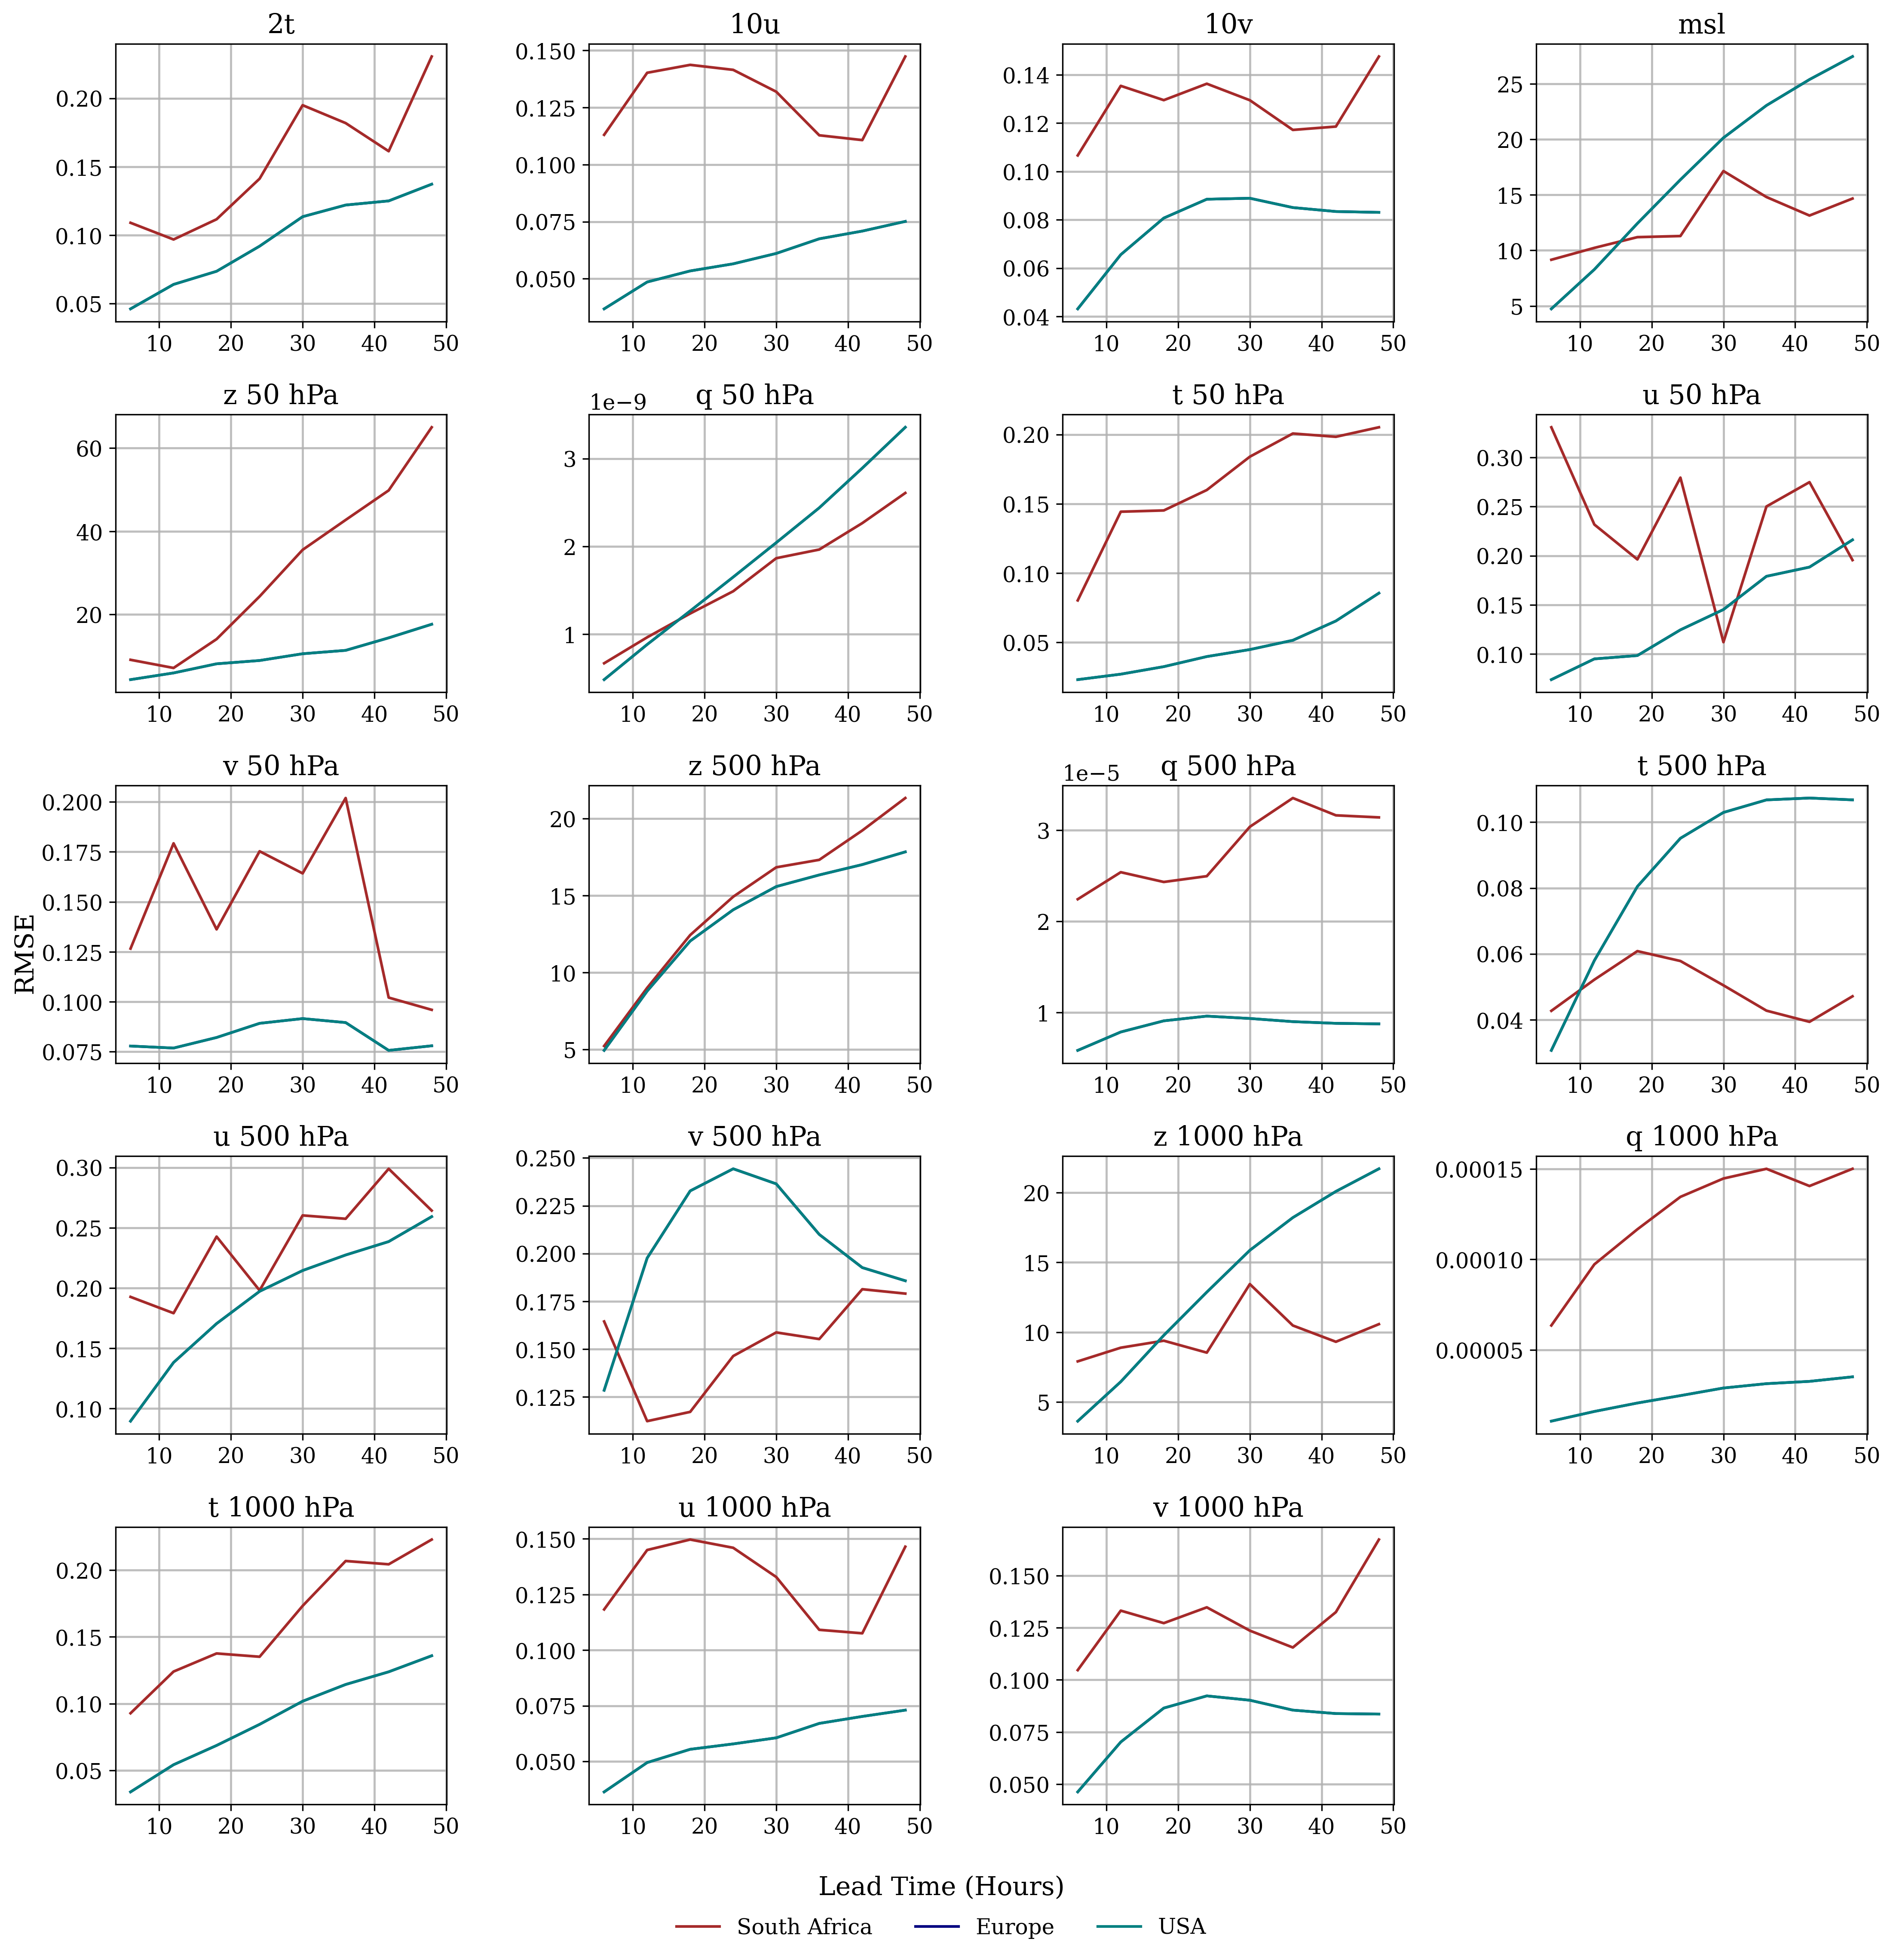

In [22]:

saving_path = "../report/evaluation/rmses_grid/pretrained_small"

fig, axs = plt.subplots(num_rows, num_plots_per_rows, dpi=300, figsize=(15, 15))
axs = axs.ravel()

# Store handles and labels from the first plot for global legend
handles, labels = None, None

for i, ax in enumerate(axs[:num_plots]):
    line1, = ax.plot(lead_time, target_region_surface_atmos_rmses[variables[i]], label="South Africa", c="brown")
    line3, = ax.plot(lead_time, eu_region_surface_atmos_rmses[variables[i]], label="Europe", c="navy")
    
    line2, = ax.plot(lead_time, base_region_surface_atmos_rmses[variables[i]], label="USA", c="teal")
    ax.set_title(variables[i])
    ax.grid(True)
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()

# Turn off unused axes
for ax in axs[num_plots:]:
    ax.axis('off')

# Add shared labels
fig.supxlabel("Lead Time (Hours)")
fig.supylabel("RMSE")

# Add a single global legend below x-axis label
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.02), frameon=False)

plt.tight_layout(pad=1.3)
plt.savefig(f"{saving_path}/sa_vs_usa.pdf", bbox_inches="tight")
plt.savefig(f"{saving_path}/sa_vs_usa.png", bbox_inches="tight")
plt.savefig(f"{saving_path}/sa_vs_usa.svg", bbox_inches="tight")


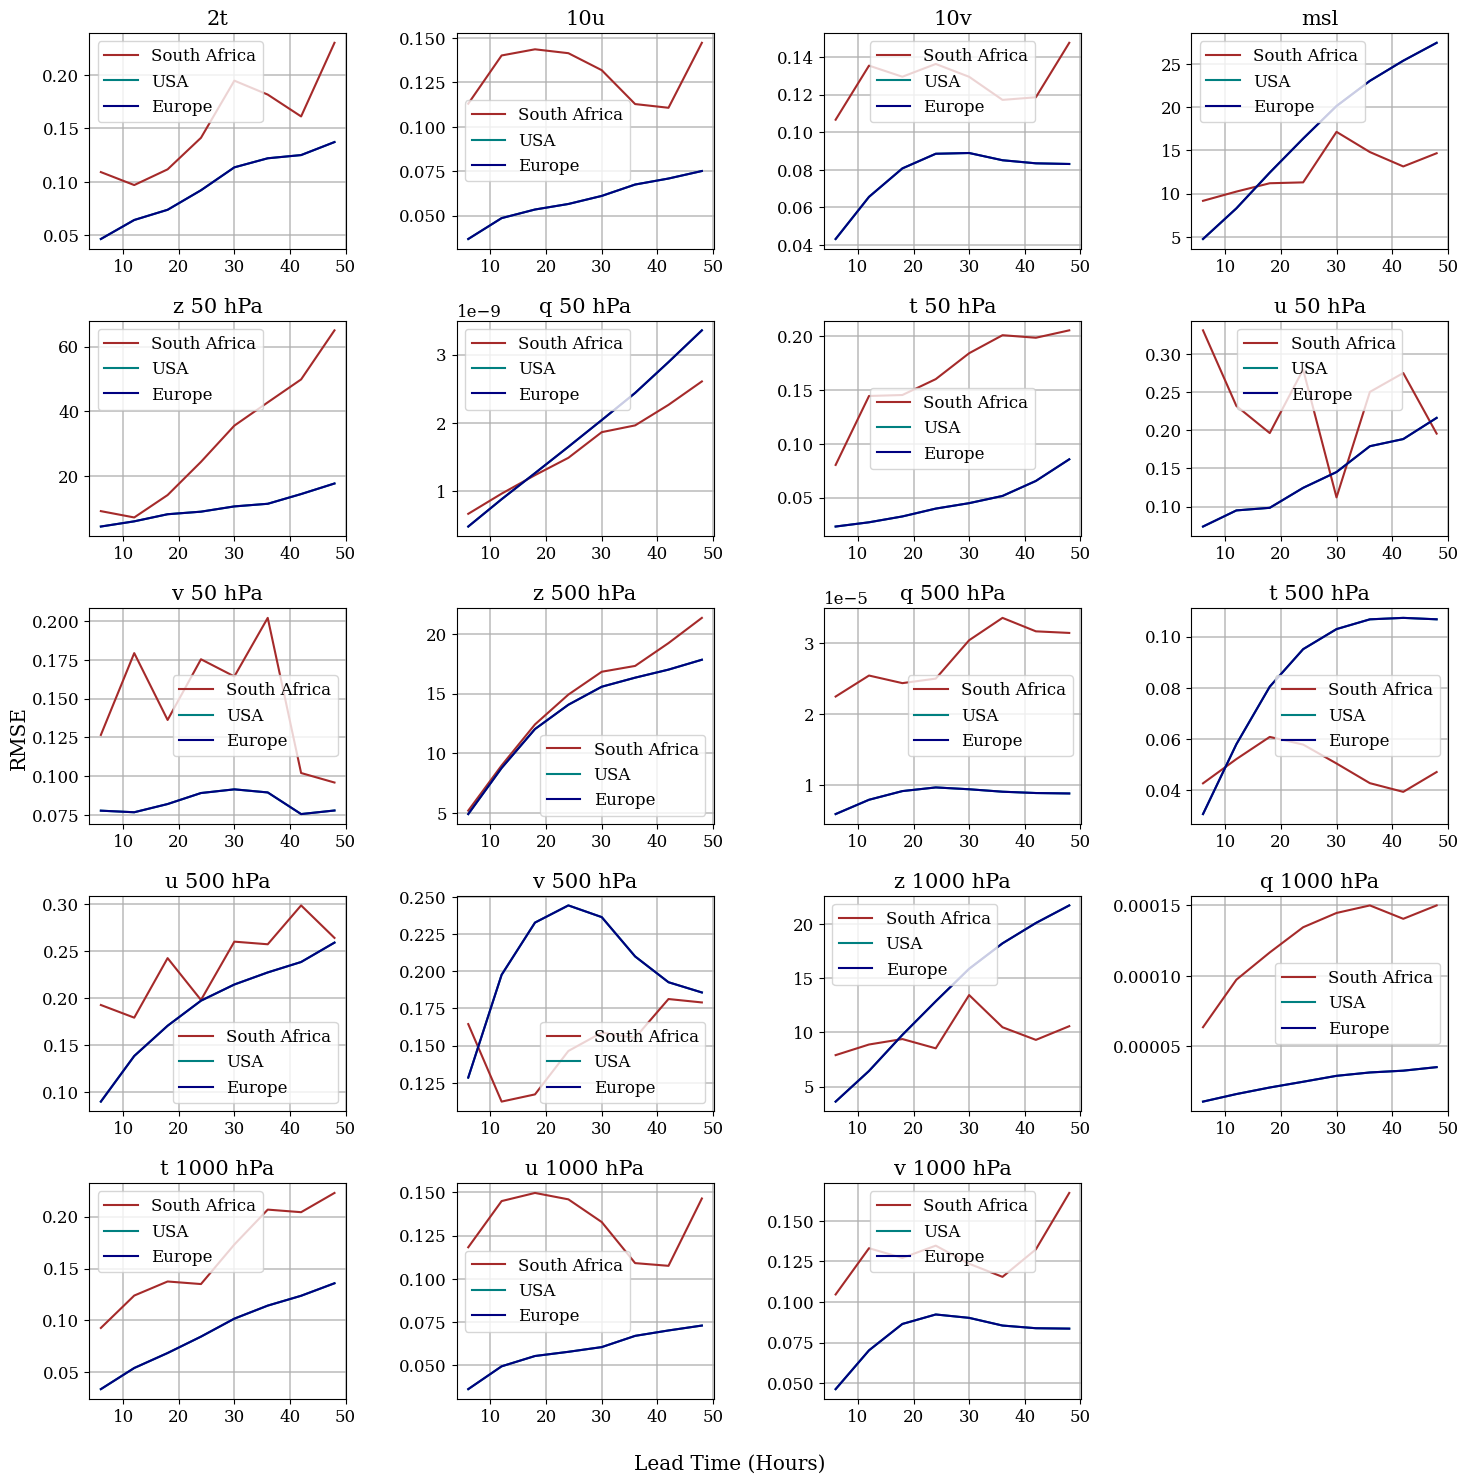

In [18]:
fig, axs = plt.subplots(num_rows, num_plots_per_rows, dpi=100, figsize=(15, 15))
axs = axs.ravel()

for i, ax in enumerate(axs[:num_plots]):
    ax.plot(lead_time, target_region_surface_atmos_rmses[variables[i]], label="South Africa", c="brown")
    ax.plot(lead_time, base_region_surface_atmos_rmses[variables[i]], label="USA", c="teal")
    ax.plot(lead_time, eu_region_surface_atmos_rmses[variables[i]], label="Europe", c="navy")
    ax.set_title(variables[i])
    ax.grid(True)
    ax.legend()  # Legend per subplot

# Turn off any unused axes
for ax in axs[num_plots:]:
    ax.axis('off')

fig.supxlabel("Lead Time (Hours)")
fig.supylabel("RMSE")

plt.tight_layout(pad=1.3)
plt.show()

AttributeError: 'Text' object has no property 'labelpad'

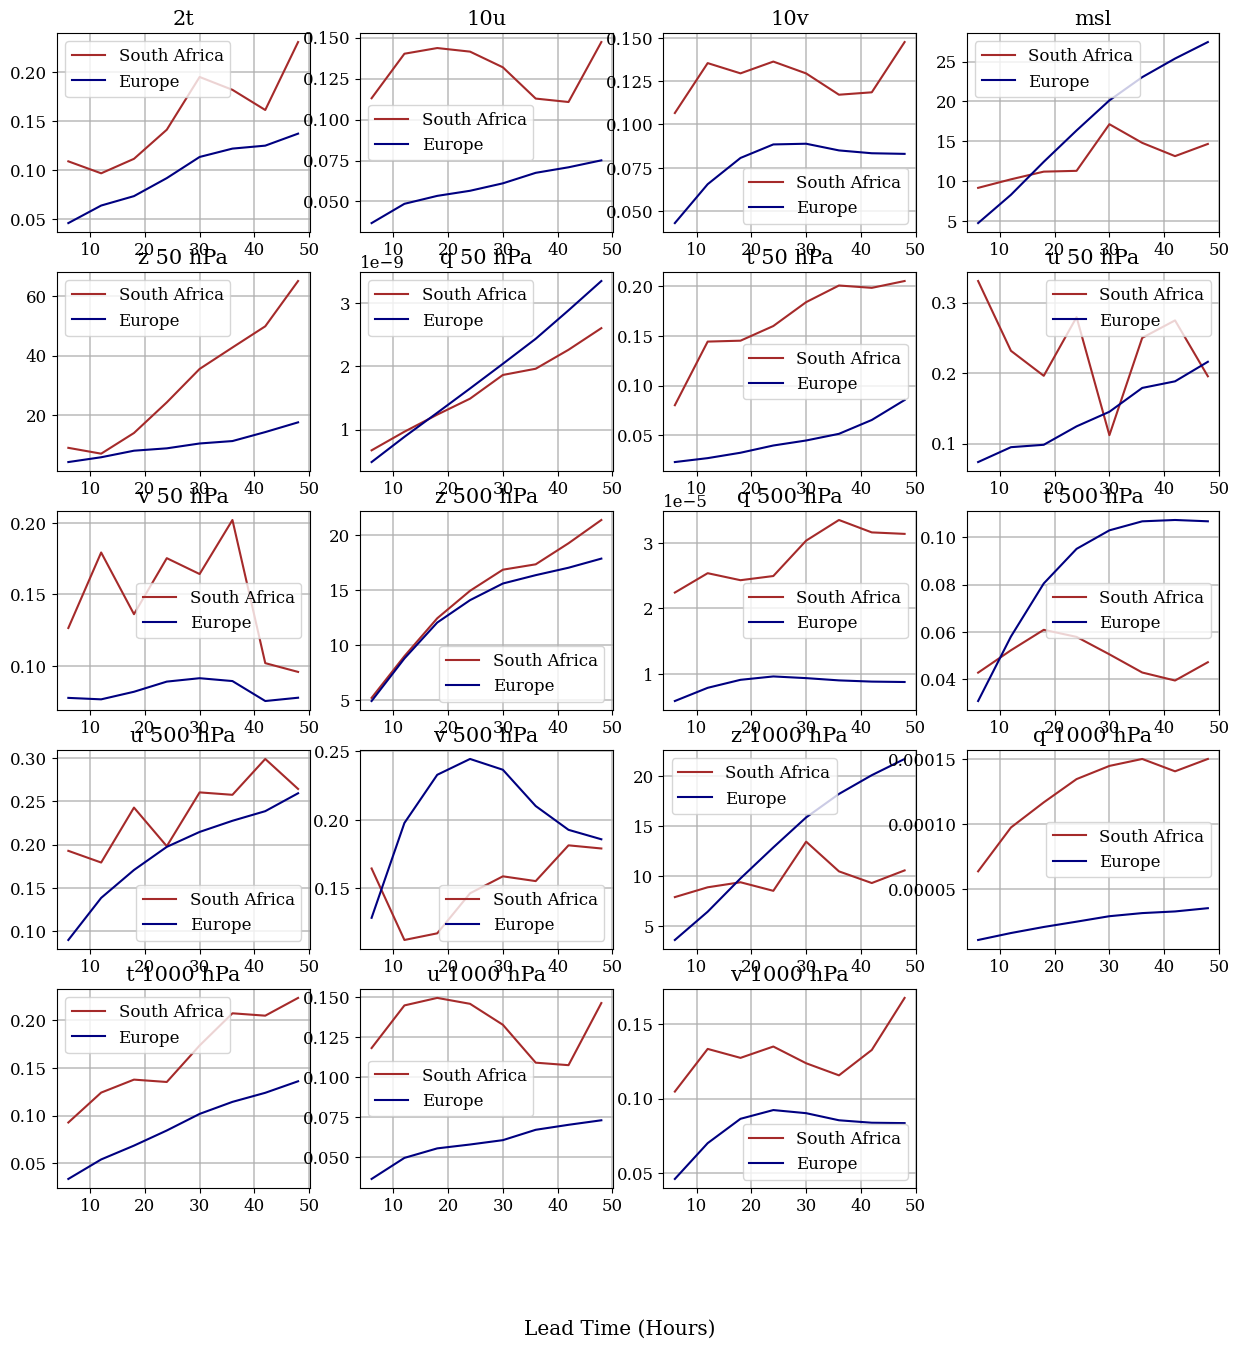

In [19]:
fig, axs = plt.subplots(num_rows, num_plots_per_rows, dpi=100, figsize=(15, 15))
axs = axs.ravel()

for i, ax in enumerate(axs[:num_plots]):
    ax.plot(lead_time, target_region_surface_atmos_rmses[variables[i]], label="South Africa", c="brown")
    ax.plot(lead_time, eu_region_surface_atmos_rmses[variables[i]], label="Europe", c="navy")
    ax.set_title(variables[i])
    ax.grid(True)
    ax.legend()  # Legend per subplot

# Turn off any unused axes
for ax in axs[num_plots:]:
    ax.axis('off')

fig.supxlabel("Lead Time (Hours)")
fig.supylabel("RMSE")

plt.tight_layout(pad=1.3)
plt.show()

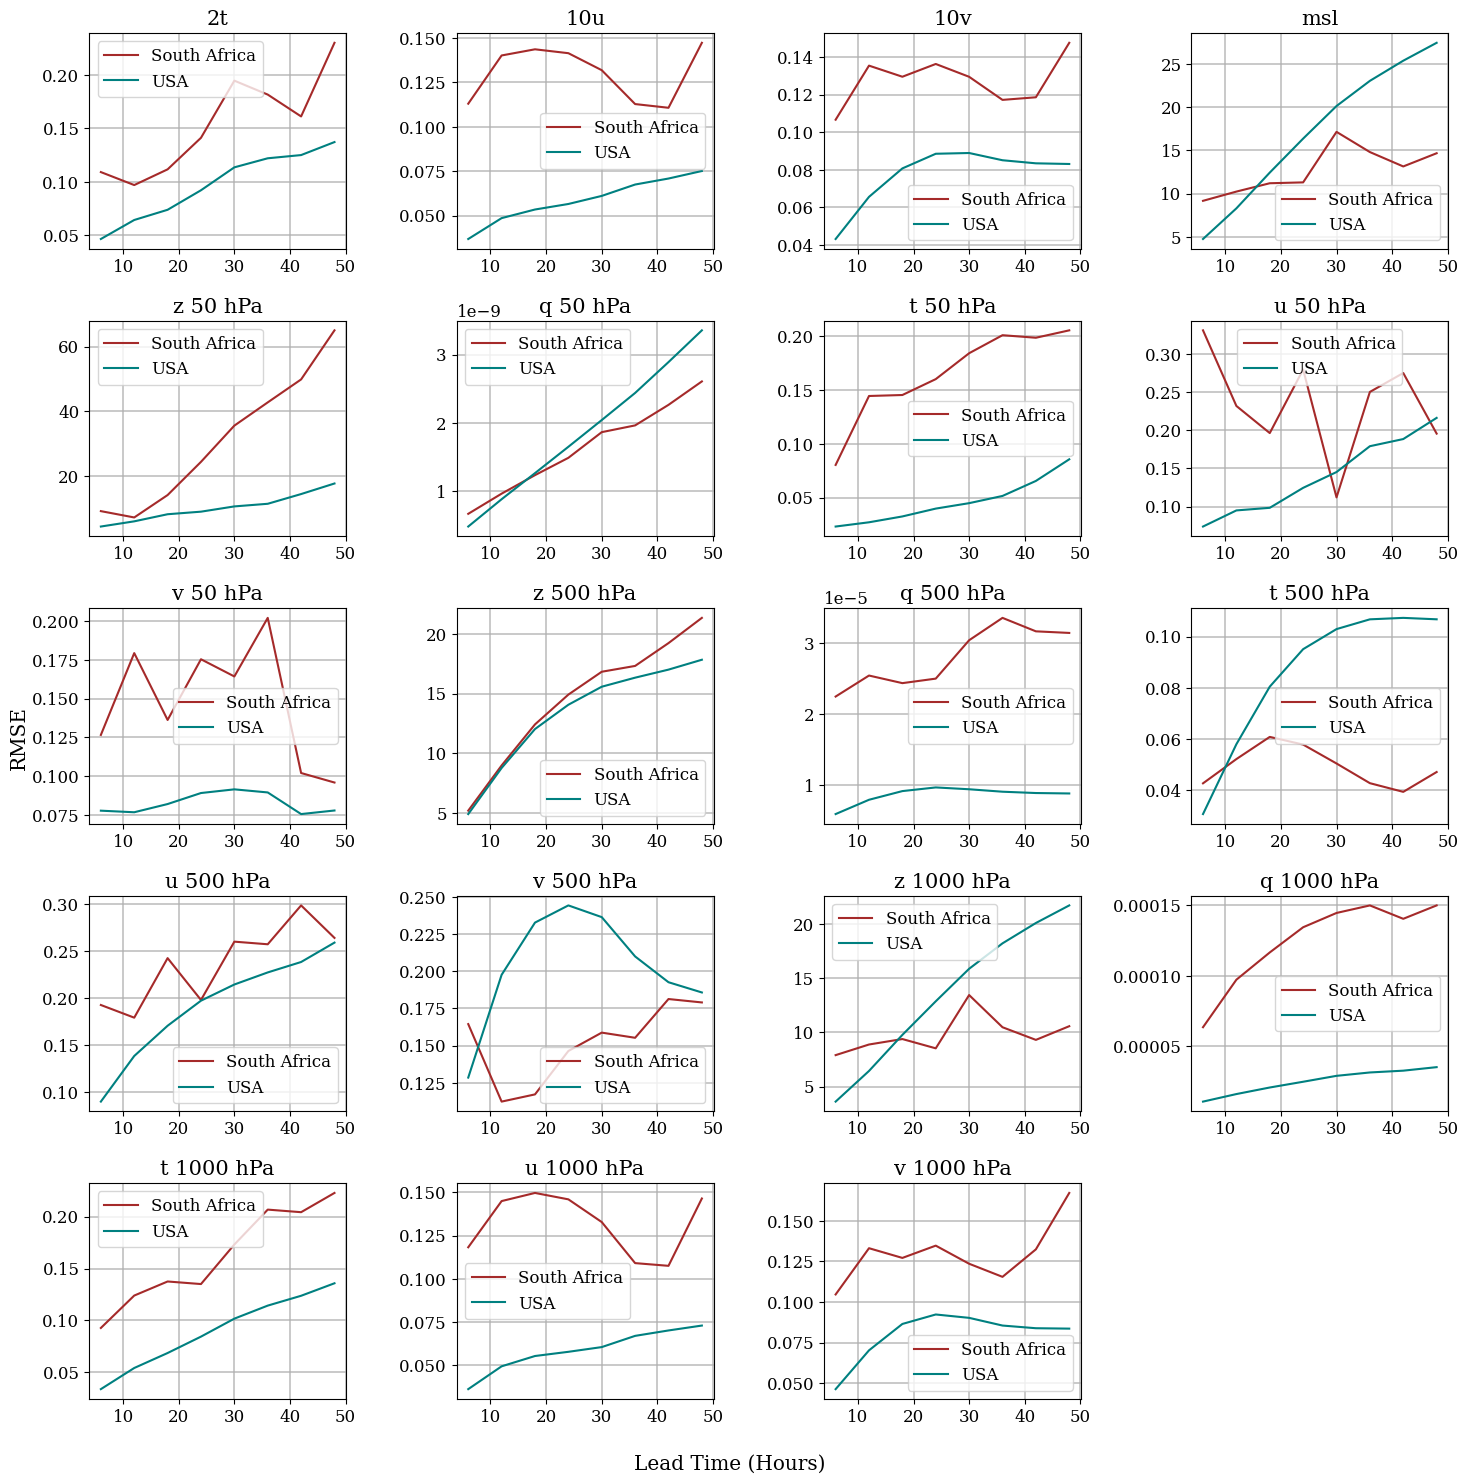

In [20]:
fig, axs = plt.subplots(num_rows, num_plots_per_rows, dpi=100, figsize=(15, 15))
axs = axs.ravel()

for i, ax in enumerate(axs[:num_plots]):
    ax.plot(lead_time, target_region_surface_atmos_rmses[variables[i]], label="South Africa", c="brown")
    ax.plot(lead_time, base_region_surface_atmos_rmses[variables[i]], label="USA", c="teal")
    ax.set_title(variables[i])
    ax.grid(True)
    ax.legend()  # Legend per subplot

# Turn off any unused axes
for ax in axs[num_plots:]:
    ax.axis('off')

fig.supxlabel("Lead Time (Hours)")
fig.supylabel("RMSE")

plt.tight_layout(pad=1.3)
plt.show()